## Анализ набора данных интернет магазина

#### Описание набора данных

Набор данных состоит из трёх файлов:
1. Файл с описанием поведения посетителей сайта ретейлера - events.csv
2. Файл с структурой каталога товаров - category_tree.csv
3. Файлов с свойствами элемента - item_properties_part1.csv, item_properties_part2.csv

Данные о поведении, то есть о таких событиях, как клики, добавление в корзину и транзакции, представляют собой взаимодействия, которые собирались в течение 4,5 месяцев. Посетитель может совершать три типа событий, а именно «просмотр», «добавить в корзину» или «транзакцию». Всего зарегистрировано 2 756 101 событие, в том числе 2 664 312 просмотров, 69 332 добавления в корзину и 22 457 транзакций, произведенных 1 407 580 уникальными посетителями.

Файл дерева категорий:  в каждой строке файла указаны идентификатор дочерней категории и соответствующий родительский элемент.

Файл свойств элемента содержит столбец временной метки, все они зависят от времени, поскольку свойства могут меняться с течением времени, например. цена, категория и т. д.


#### Цели проведения анализа данных:

1. Необходимо произвести очистку данных: удалить дубликаты, пропуски данных
2. Произвести анализ на основе данных: посещаемость сайта интернет магазина, популярные товары, определить свойства товаров, которые влияют на целевые действия покупателей.
3. Рассчитать конверсию

#### Этапы проведения анализа данных:

1. Обзор данных
2. Предварительная обработка данных
3. Анализ данных
4. Выводы

### Обзор данных

In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [2]:
# Загружаем все данные
data_events = pd.read_csv('events.csv')
data_category = pd.read_csv('category_tree.csv')
data_properties_1 = pd.read_csv('item_properties_part1.csv')
data_properties_2 = pd.read_csv('item_properties_part2.csv')

#### Файл с описанием поведения посетителей сайта

In [3]:
data_events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [4]:
data_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


Данные представлены в следующих столбцах:
* timestamp - содержит стандартную временную метку UNIX события
* visitorid - уникальный идентификатор посетителя
* event - событие, совершенное посетителем сайта
* itemid - уникальный идентификатор товара
* transactionid - уникальный идентификатор транзакции

In [5]:
data_events.describe()

,timestamp,visitorid,itemid,transactionid
count,2.756101e+06,2.756101e+06,2.756101e+06,22457.000000
mean,1.436424e+12,7.019229e+05,2.349225e+05,8826.497796
std,3.366312e+09,4.056875e+05,1.341954e+05,5098.996290
min,1.430622e+12,0.000000e+00,3.000000e+00,0.000000
25%,1.433478e+12,3.505660e+05,1.181200e+05,4411.000000
50%,1.436453e+12,7.020600e+05,2.360670e+05,8813.000000
75%,1.439225e+12,1.053437e+06,3.507150e+05,13224.000000
max,1.442545e+12,1.407579e+06,4.668670e+05,17671.000000


Какие события совершают посетители сайта:

In [6]:
data_events['event'].value_counts()

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64

Посетители соверщают следующие события:
1. Просмотр товара
2. Добавление товара в корзину
3. Покупка товара

Определим количество уникальных товаров и количество уникальных пользователей сайта:

In [7]:
data_events['visitorid'].nunique()

1407580

In [8]:
data_events['itemid'].nunique()

235061

#### Файл со структурой каталога товара

In [9]:
data_category.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [10]:
data_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


Данные представлены следующими столбцами:
* categoryid - уникальный идентификатор категории товаров
* parentid - идентификатор родительской категории

Если родительская категория отсутствует- данные в parentid будут отсутствовать

In [11]:
data_category.describe()

,categoryid,parentid
count,1669.000000,1644.000000
mean,849.285201,847.571168
std,490.195116,505.058485
min,0.000000,8.000000
25%,427.000000,381.000000
50%,848.000000,866.000000
75%,1273.000000,1291.000000
max,1698.000000,1698.000000


#### Файл со свойствами элемента

In [12]:
data_properties_1.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [13]:
data_properties_2.head()

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062


In [14]:
data_properties_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 335.7+ MB


In [15]:
data_properties_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9275903 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 283.1+ MB


Файл содержит данные в следующих столбцах:
* timestamp - содержит стандартную временную метку UNIX события
* itemid - уникальный идентификатор товара
* property  - свойство товара. Данные были хешированы, кроме 'categotyid'(уникальный идентификатор категории товара) и 'available'(свойство "В наличии")

In [16]:
data_properties_1.describe()

,timestamp,itemid
count,1.100000e+07,1.100000e+07
mean,1.435158e+12,2.333851e+05
std,3.327653e+09,1.348258e+05
min,1.431227e+12,0.000000e+00
25%,1.432436e+12,1.165150e+05
50%,1.433646e+12,2.334990e+05
75%,1.437880e+12,3.501860e+05
max,1.442113e+12,4.668660e+05


In [17]:
data_properties_2.describe()

,timestamp,itemid
count,9.275903e+06,9.275903e+06
mean,1.435156e+12,2.333968e+05
std,3.327970e+09,1.348682e+05
min,1.431227e+12,0.000000e+00
25%,1.432436e+12,1.165175e+05
50%,1.433646e+12,2.334620e+05
75%,1.437880e+12,3.504470e+05
max,1.442113e+12,4.668660e+05


### Предварительная обработка данных

#### Проверим данные на повторы и отсутствующие значения

**В файле с поведением посетителей сайта:**

In [18]:
data_events.duplicated().sum()

460

Присутствуют дубликаты, так как в одно и тоже время разные посетители совершают действия на сайте и так же посетитель может заходить на сайт повторно и совершать дополнительные действия

In [19]:
data_events.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

 Пропуски в данных отсутствуют

#### В файле с деревом категорий:

In [20]:
data_category.duplicated().sum()

0

Дубликаты категорий отсутствуют

In [21]:
data_category.isnull().sum()

categoryid     0
parentid      25
dtype: int64

В идентификаторах категорий нет отсутствующих значений. В индентификаторах родительских категорий такие данные есть- так как не у всех категорий имеются родительские категории.

#### В файле со свойствами элемента:

In [22]:
data_properties_1.duplicated().sum()

0

In [23]:
data_properties_2.duplicated().sum()

0

In [24]:
data_properties_1.isnull().sum()

timestamp    0
itemid       0
property     0
value        0
dtype: int64

In [25]:
data_properties_2.isnull().sum()

timestamp    0
itemid       0
property     0
value        0
dtype: int64

В данных нет дубликатов и отсутствующих значений

#### Объеденим две таблицы со свойствами элемента в одну:

In [26]:
data_properties = pd.concat([data_properties_1, data_properties_2])

In [27]:
data_properties.sample(5)

,timestamp,itemid,property,value
10428030,1431831600000,31179,6,1128307 150169 634180 30603 674092
8640887,1433041200000,320297,369,488660
8038528,1435460400000,304906,280,769062
4504896,1432436400000,26844,810,n2580.000 424566
8830016,1439694000000,60252,888,454345 356016 1160198


#### Приведем временные метки к типу данных 'datetime', как наиболее привычный для восприятия:

In [28]:
data_events['timestamp'] = pd.to_datetime(data_events['timestamp'], unit = 'ms') 
data_properties_1['timestamp'] = pd.to_datetime(data_properties_1['timestamp'], unit = 'ms')
data_properties_2['timestamp'] = pd.to_datetime(data_properties_2['timestamp'], unit = 'ms')

In [29]:
data_events.sample(5)

,timestamp,visitorid,event,itemid,transactionid
2137696,2015-07-05 23:08:46.409,529802,view,104663,NaN
1940332,2015-05-24 18:37:56.580,1348163,view,55395,NaN
1817713,2015-05-19 22:21:57.658,1332864,view,170999,NaN
81661,2015-06-04 15:35:35.593,1134860,view,230947,NaN
2082595,2015-07-02 19:02:25.670,400795,view,322946,NaN


In [30]:
data_properties_1.sample(5)

,timestamp,itemid,property,value
7452203,2015-05-10 03:00:00,367985,159,519769
8338973,2015-06-07 03:00:00,332715,888,398067 n687969276.000 992862 647924 221748 128...
5152832,2015-05-10 03:00:00,397804,917,372106 n2556.000
4827492,2015-05-17 03:00:00,106731,451,1141052 n25.200
776888,2015-05-10 03:00:00,443332,790,n600.000


In [31]:
data_properties_2.sample(5)

,timestamp,itemid,property,value
941841,2015-09-06 03:00:00,96216,678,569912
2285865,2015-08-30 03:00:00,397323,888,1145858
5321680,2015-05-10 03:00:00,166223,888,624059
2766277,2015-05-31 03:00:00,42314,931,814297 670753 n96.000
7877257,2015-09-13 03:00:00,354718,591,1116693


Теперь когда даты приведены к привычным значениям, определим за какой период произведен отбор данных

In [32]:
data_events['timestamp'].min()

Timestamp('2015-05-03 03:00:04.384000')

In [33]:
data_events['timestamp'].max()

Timestamp('2015-09-18 02:59:47.788000')

Временной интервал, за который собрали данные с 03.05.2015 по 18.09.2015

### Анализ данных

#### Рассмотрим действия посетителей в разные периоды времени. 

Для этого создадим два новых столбца в таблице data_events:  в один столбец извлечем день недели из даты, в другой время.

In [34]:
data_events['day'] = data_events['timestamp'].dt.day_name()
data_events['hour'] = data_events['timestamp'].dt.hour

In [35]:
data_events.head()

,timestamp,visitorid,event,itemid,transactionid,day,hour
0,2015-06-02 05:02:12.117,257597,view,355908,NaN,Tuesday,5
1,2015-06-02 05:50:14.164,992329,view,248676,NaN,Tuesday,5
2,2015-06-02 05:13:19.827,111016,view,318965,NaN,Tuesday,5
3,2015-06-02 05:12:35.914,483717,view,253185,NaN,Tuesday,5
4,2015-06-02 05:02:17.106,951259,view,367447,NaN,Tuesday,5


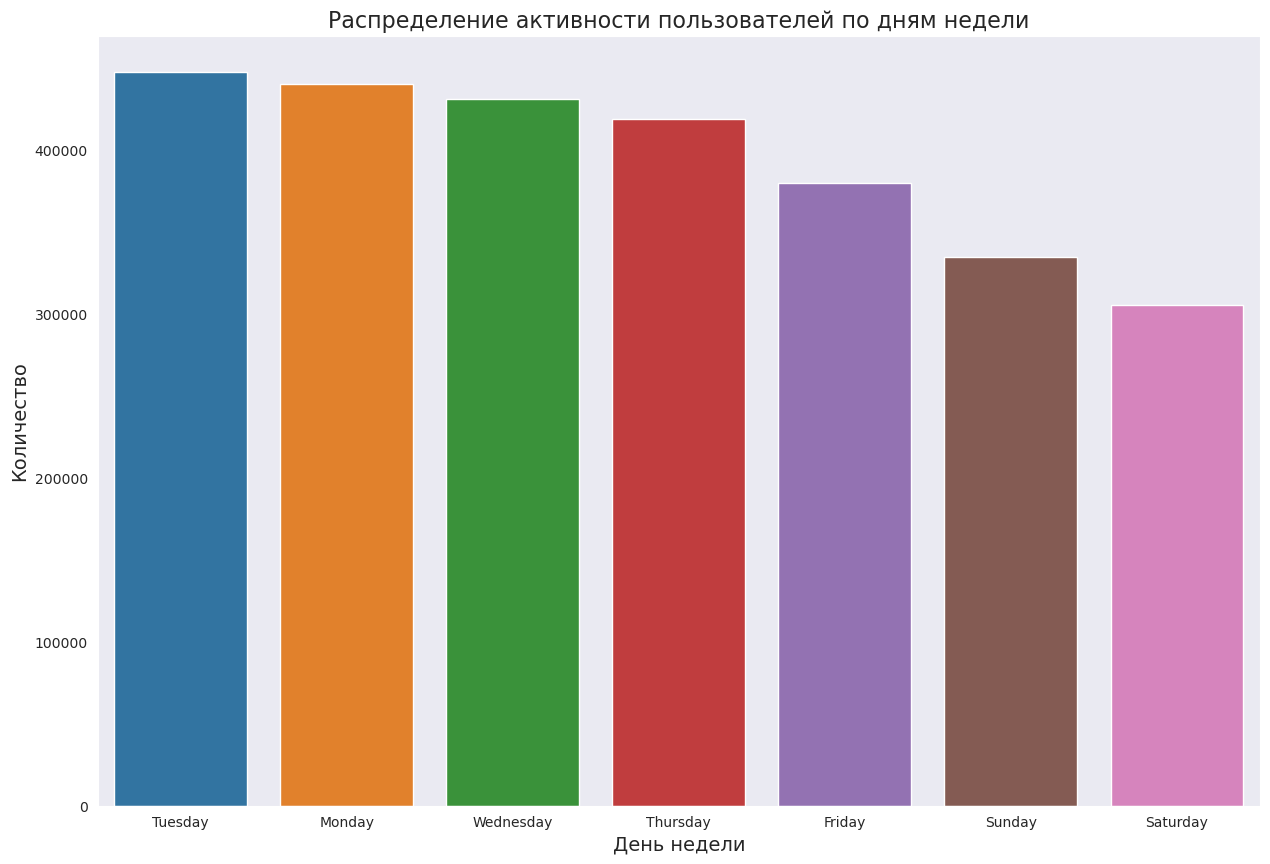

In [36]:
plt.figure(figsize = (15, 10))
sns.set_style('dark')
sns.countplot(data_events, x = 'day', order = data_events['day'].value_counts().index)
plt.title('Распределение активности пользователей по дням недели', fontsize = 16)
plt.xlabel('День недели', fontsize = 14)
plt.ylabel('Количество', fontsize = 14)
plt.show()

Самая наименьшая активность наблюдается в субботу, самая максимальная во вторник. В течении рабочих дней наблюдается высокая активность пользователей. С максимального дня- вторника, идет постепенное снижение активности пользователей и минимум достигается в субботу, затем происходит востепенное увеличение с воскресенья по вторник.

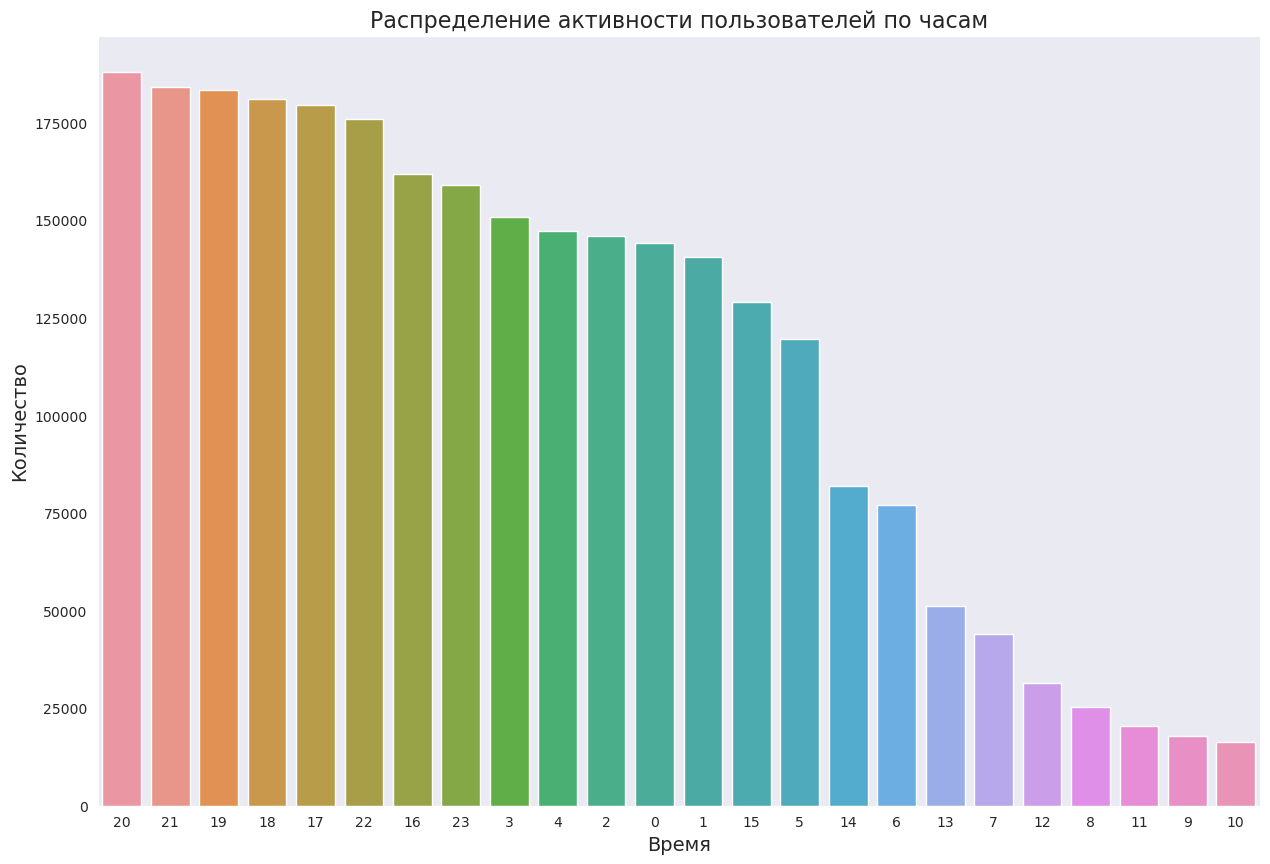

In [37]:
plt.figure(figsize = (15, 10))
sns.countplot(data_events, x = 'hour', order = data_events['hour'].value_counts().index)
plt.title('Распределение активности пользователей по часам', fontsize = 16)
plt.xlabel('Время', fontsize = 14)
plt.ylabel('Количество', fontsize = 14)
plt.show()

Наибольшее количество активностей приходится на вечернее время- пик достигается в 8 часов вечера. Самая низкая активность наблюдается в утренние часы с минимумом в 10 часов утра.

Вывод на основании визуализации: максимальная активность пользователей наблюдается в рабочие дни недели в вечернее время.

#### Рассмотрим распределение активности пользователей по типу:

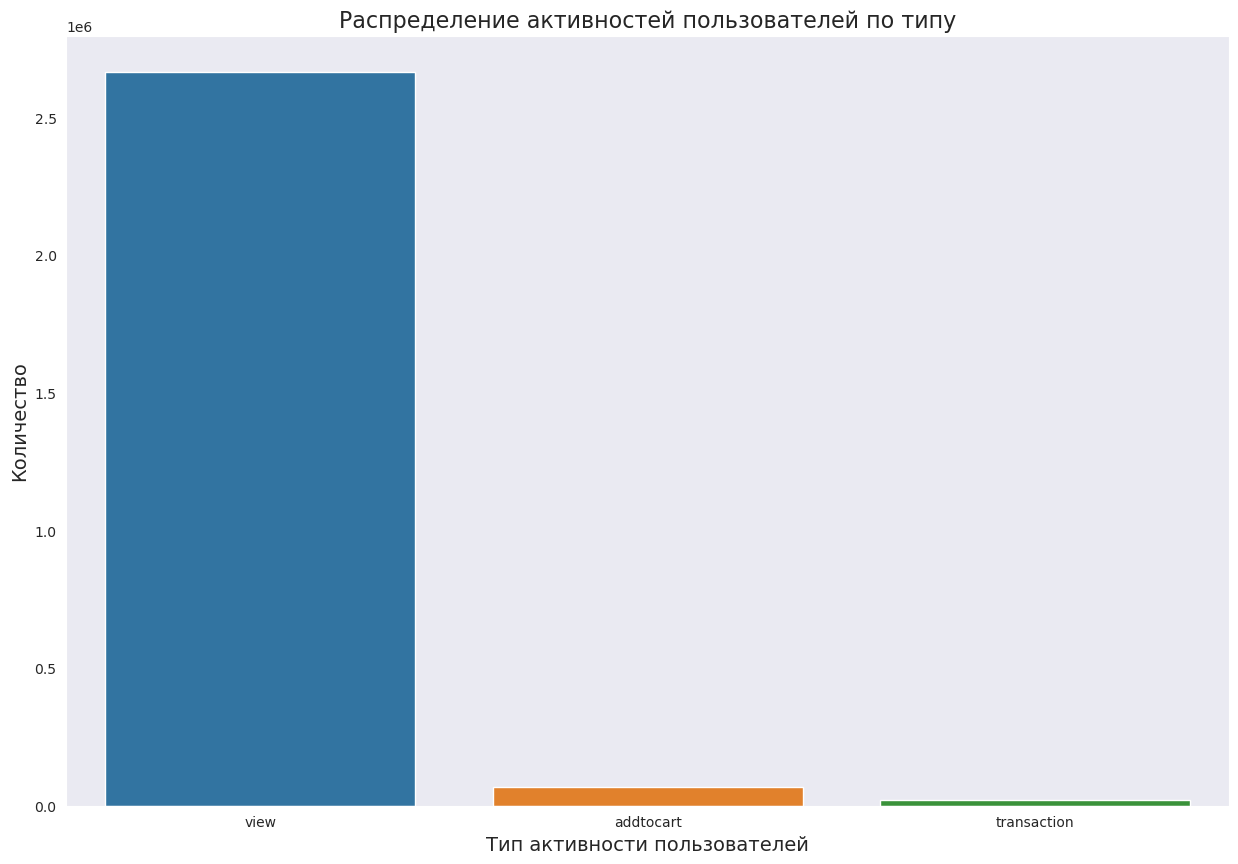

In [38]:
plt.figure(figsize = (15, 10))
sns.countplot(data_events, x = data_events['event'])
plt.title('Распределение активностей пользователей по типу', fontsize = 16)
plt.xlabel('Тип активности пользователей', fontsize = 14)
plt.ylabel('Количество', fontsize = 14)
plt.show()

На полученной диаграмме видно соотношение активностей пользователей. Самая большая активность- это просмотр товаров. Самая наименьшая- покупка.
Получаем в среднем следующее распределение:


In [39]:
data_events['event'].value_counts()

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64

#### Рассмотрим топ товаров по просмотрам, добавлению в корзину и покупкам:

In [40]:
# Получаем топ 20 товаров по просмотрам
top_item_view = data_events[data_events['event'] == 'view']['itemid'].value_counts().head(20)

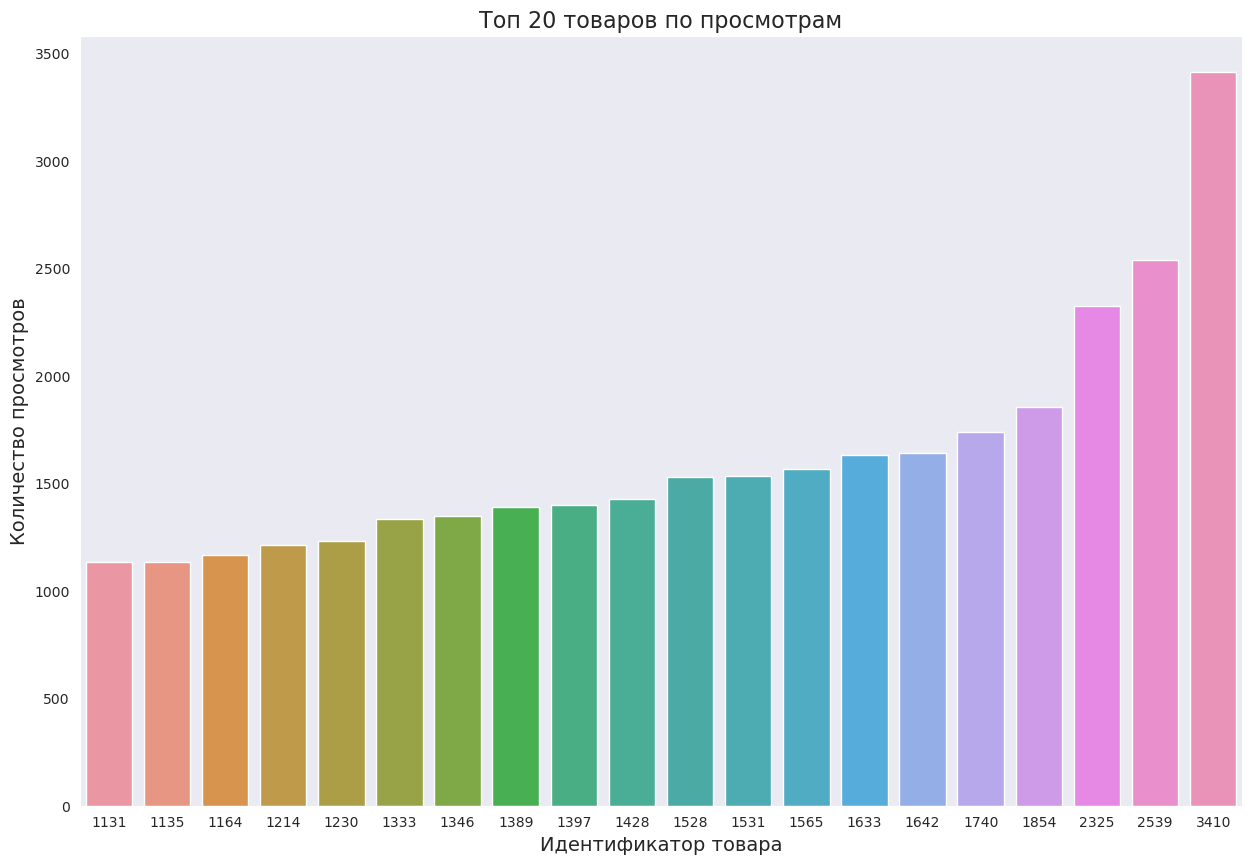

In [41]:
plt.figure(figsize = (15, 10))
sns.barplot(top_item_view, x = top_item_view.index, y = top_item_view.values)
plt.title('Топ 20 товаров по просмотрам', fontsize = 16)
plt.xlabel('Идентификатор товара', fontsize = 14)
plt.ylabel('Количество просмотров', fontsize = 14)
plt.show()

In [42]:
# Получаем топ 20 товаров по добавлению в корзину
top_item_addtocart = data_events[data_events['event'] == 'addtocart']['itemid'].value_counts().head(20)

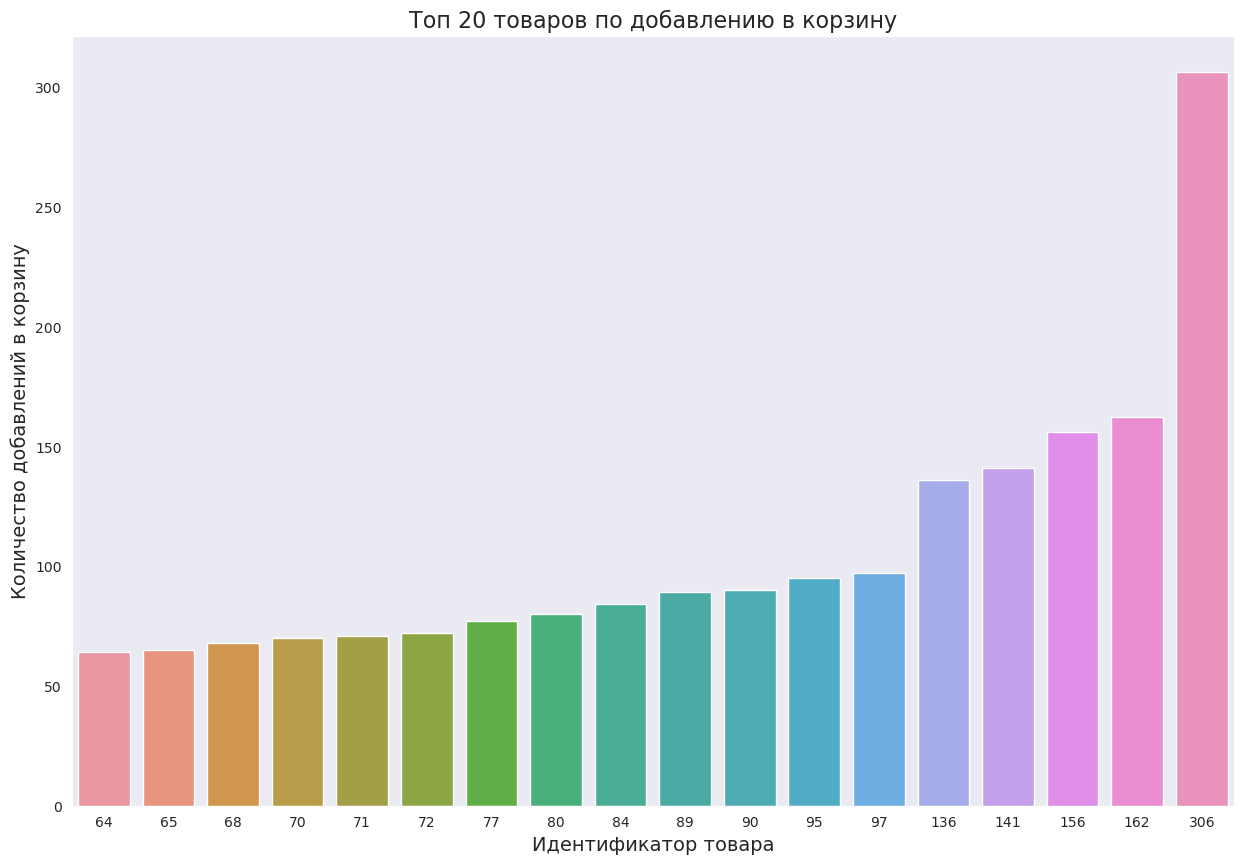

In [43]:
plt.figure(figsize = (15, 10))
sns.barplot(top_item_addtocart, x = top_item_addtocart.index, y = top_item_addtocart.values)
plt.title('Топ 20 товаров по добавлению в корзину', fontsize = 16)
plt.xlabel('Идентификатор товара', fontsize = 14)
plt.ylabel('Количество добавлений в корзину', fontsize = 14)
plt.show()

In [44]:
# Получаем топ 20 товаров по покупкам
top_item_transaction = data_events[data_events['event'] == 'transaction']['itemid'].value_counts().head(20)

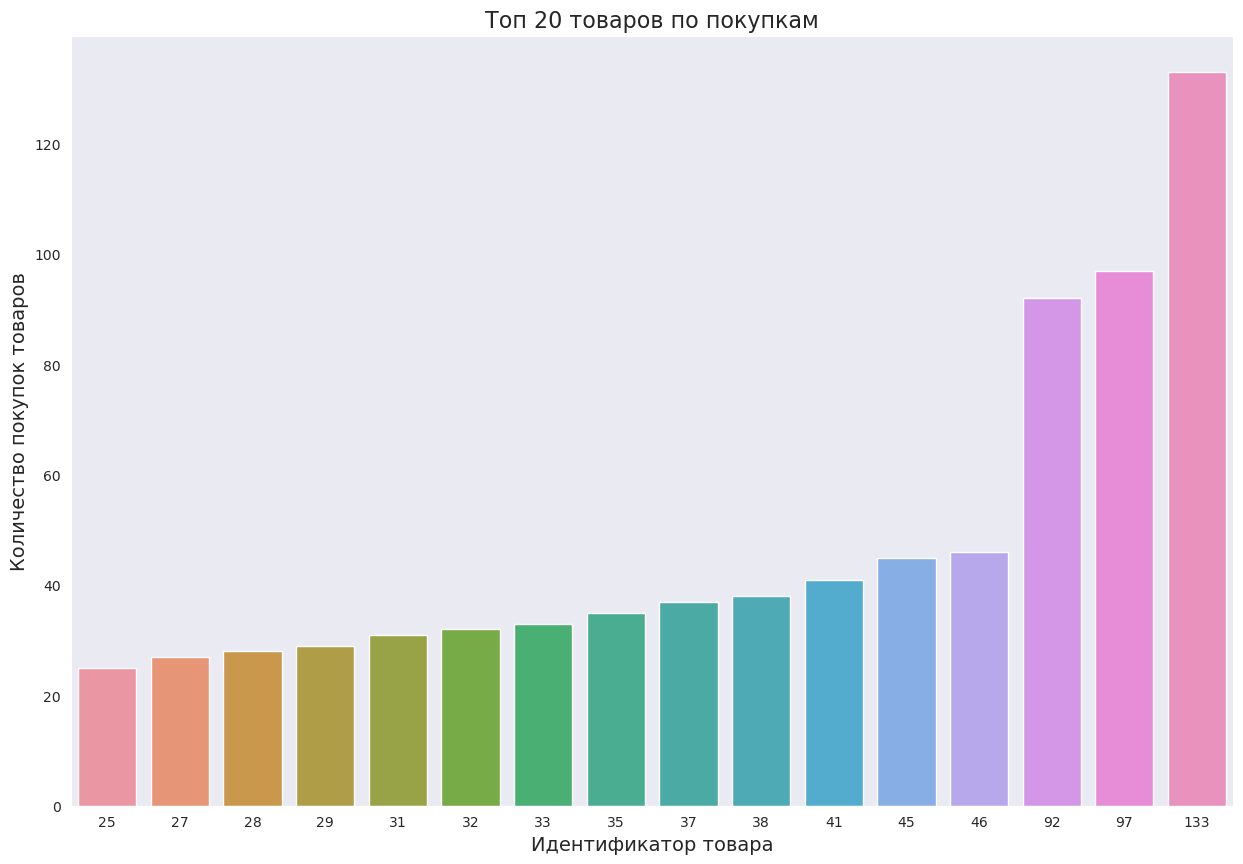

In [45]:
plt.figure(figsize = (15, 10))
sns.barplot(top_item_transaction, x = top_item_transaction.index, y = top_item_transaction.values)
plt.title('Топ 20 товаров по покупкам', fontsize = 16)
plt.xlabel('Идентификатор товара', fontsize = 14)
plt.ylabel('Количество покупок товаров', fontsize = 14)
plt.show()

Лидерами продаж являются товары, которые не являются лидерами по добавлению в корзину(исключение товар 97). Также товары в топ 20 просмотров не явлеются лидерами по добавлению в корзину и покупке.

#### Рассмотрим топ самых активных пользователей сайта:

In [46]:
#Группируем тип действий на сайте по пользователям:
group_visitor_event = data_events.groupby('visitorid')['event'].count().reset_index()
group_visitor_event.rename(columns = {'event': 'count_event'}, inplace = True)

# Сортируем по убыванию
group_visitor_event.sort_values(by = 'count_event', ascending = False, inplace = True)

# Выбираем топ- 20 активных пользователей
top_visitor_event = group_visitor_event.head(20)

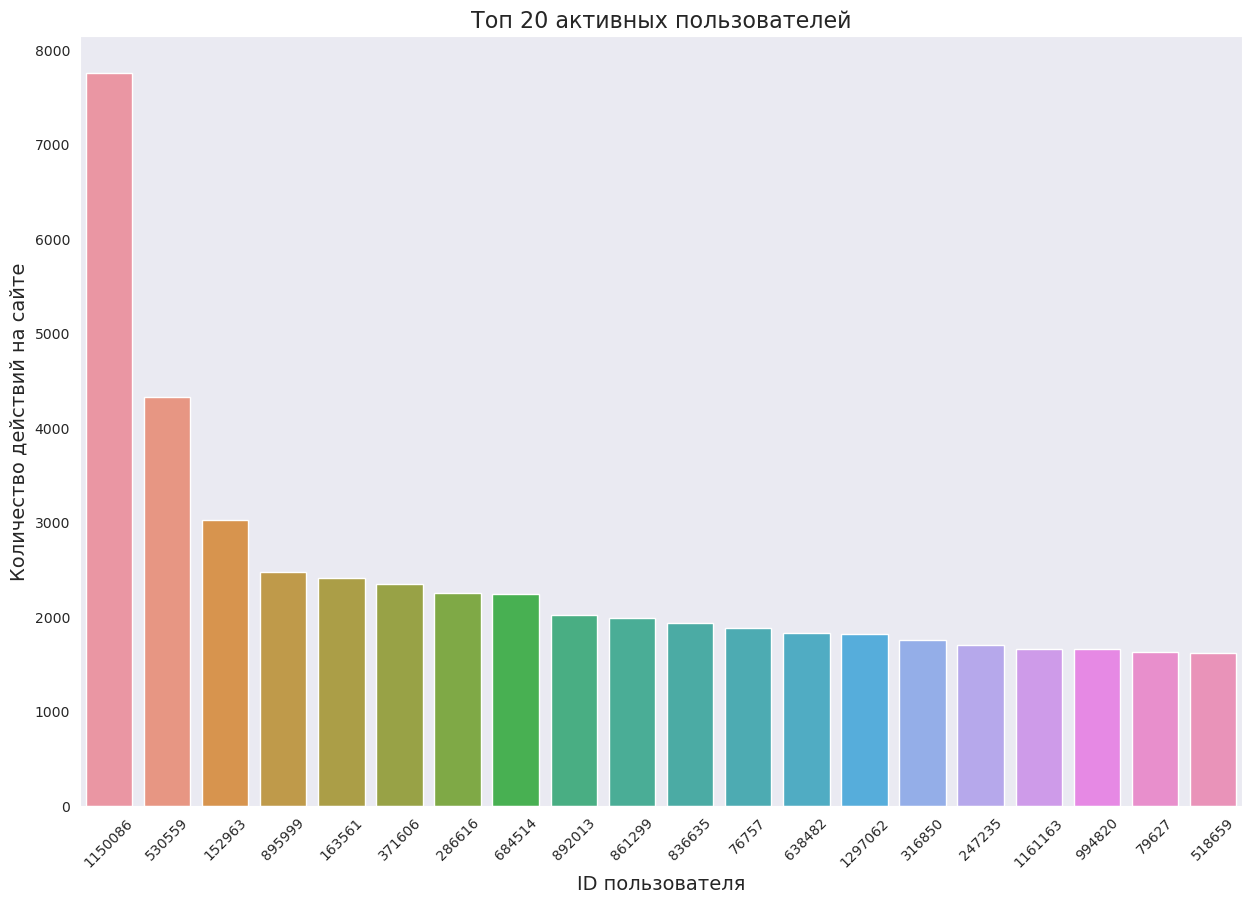

In [47]:
plt.figure(figsize = (15, 10))
sns.barplot(top_visitor_event, x = 'visitorid', y = 'count_event', order = top_visitor_event['count_event'].index)
plt.title('Топ 20 активных пользователей', fontsize = 16)
plt.xlabel('ID пользователя', fontsize = 14)
plt.ylabel('Количество действий на сайте', fontsize = 14)
plt.xticks(rotation = 45)
plt.show()

#### Рассмотрим свойства товаров из топ по просмотрам, добавлению в корзину  и покупкам

**Находим общие свойства товаров из топ 20 по просмотрам**

In [48]:
# Получаем список идентификаторов товаров из топ 20 по просмотрам
list_top_view = top_item_view.index.to_list()

# Выбираем  свойства топ 20 товаров из таблицы со свойствами товаров

# Создаем пустое множество для хранения свойств товаров
property_list_view = set()
# Для подсчета общих свойств товаров в топ 20 создаем список 
full_property_list_view = []

# Создаем словарь для хранения товара и его свойств
property_view = {}

# Создаем цикл для извлечения свойст товаров
for item in list_top_view:
    list_property = sorted(list(set(data_properties.loc[data_properties['itemid'] == item]['property'].values.tolist())))
    set_prop = set(data_properties.loc[data_properties['itemid'] == item]['property'].values.tolist())
    property_view[item] = list_property
    property_list_view = property_list_view.union(set_prop)
    full_property_list_view = full_property_list_view + list_property
    
# Преобразуем множество в отсортированный список
property_list_view = sorted(list(property_list_view))

# Создаем словарь из списка свойств товара
dict_property = dict(Counter(full_property_list_view))
sort_dict_property = dict(sorted(dict_property.items(), key = lambda item: item[1], reverse = True))

# Преобразуем словарь в DataFrame
data_top_view_property = pd.DataFrame(sort_dict_property, index=[0])

In [49]:
# Визуализируем только 20 совпадающие свойства
data_top_view_property.iloc[:,:21]

,112,159,202,283,364,678,764,776,790,839,...,917,available,categoryid,6,698,227,1036,591,689,1066
0,20,20,20,20,20,20,20,20,20,20,...,20,20,20,18,17,16,12,10,7,7


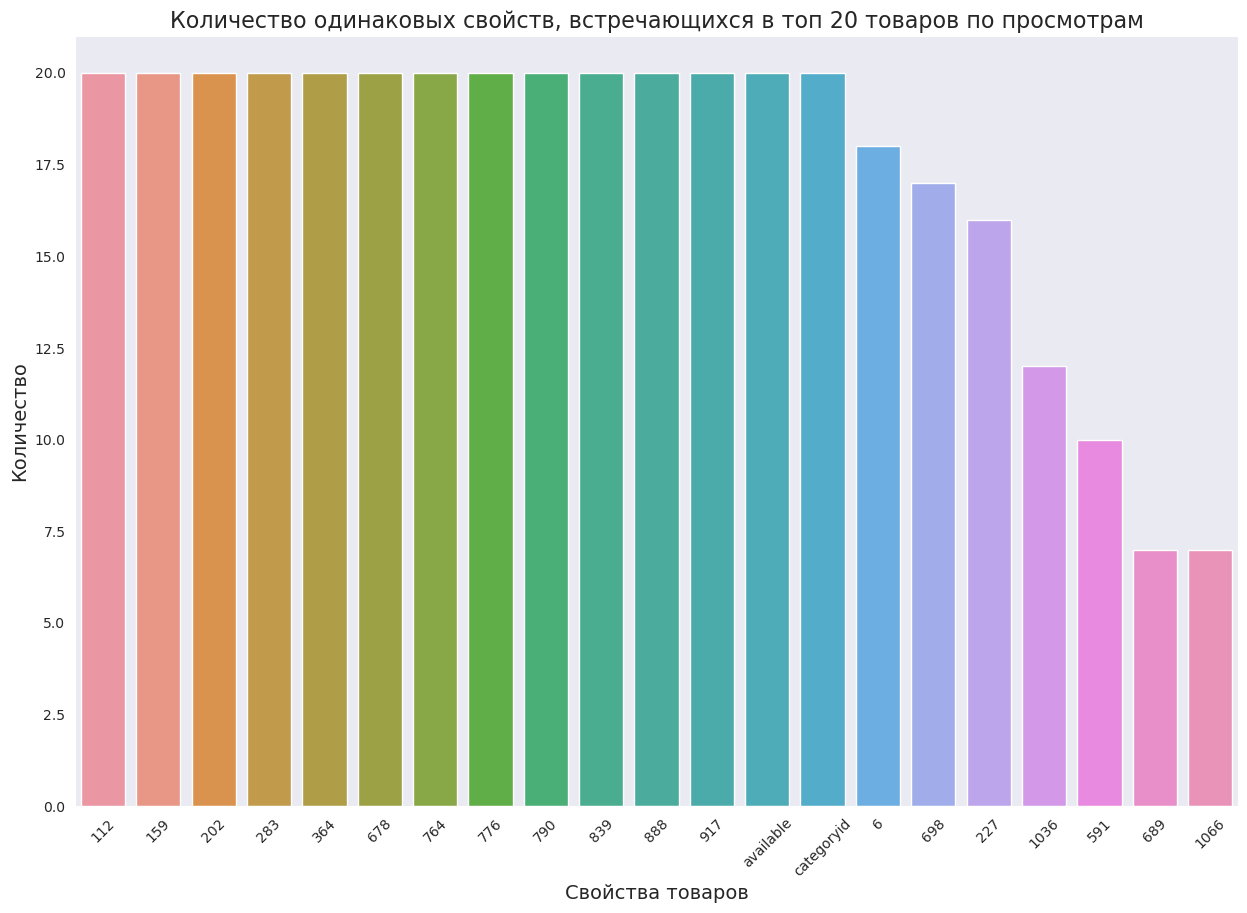

In [50]:
plt.figure(figsize = (15, 10))
sns.barplot(data_top_view_property.iloc[:,:21])
plt.title('Количество одинаковых свойств, встречающихся в топ 20 товаров по просмотрам', fontsize = 16)
plt.xlabel('Свойства товаров', fontsize = 14)
plt.ylabel('Количество', fontsize = 14)
plt.xticks(rotation = 45)
plt.show()

Все топ 20 товаров по просмотрам объединяет 14 общих свойств.

**Находим общие свойства товаров из топ 20 по добавлению в корзину**

In [51]:
# Получаем список идентификаторов товаров из топ 20 по добавлению в корзину
list_top_addtocart = top_item_addtocart.index.to_list()

# Выбираем  свойства топ 20 товаров из таблицы со свойствами товаров

# Создаем пустое множество для хранения свойств товаров
property_list_addtocart = set()
# Для подсчета общих свойств товаров в топ 20 создаем список 
full_property_list_addtocart = []

# Создаем словарь для хранения товара и его свойств
property_addtocart = {}

# Создаем цикл для извлечения свойст товаров
for item in list_top_addtocart:
    list_property = sorted(list(set(data_properties.loc[data_properties['itemid'] == item]['property'].values.tolist())))
    set_prop = set(data_properties.loc[data_properties['itemid'] == item]['property'].values.tolist())
    property_addtocart[item] = list_property
    property_list_addtocart = property_list_addtocart.union(set_prop)
    full_property_list_addtocart = full_property_list_addtocart + list_property
    
# Преобразуем множество в отсортированный список
property_list_addtocart = sorted(list(property_list_addtocart))

# Создаем словарь из списка свойств товара
dict_property_addtocart = dict(Counter(full_property_list_addtocart))
sort_dict_property_addtocart = dict(sorted(dict_property_addtocart.items(), key = lambda item: item[1], reverse = True))

# Преобразуем словарь в DataFrame
data_top_addtocart_property = pd.DataFrame(sort_dict_property_addtocart, index=[0])

In [52]:
# Визуализируем только 20 совпадающие свойства
data_top_addtocart_property.iloc[:,:21]

,112,159,202,283,364,678,764,776,790,888,...,available,categoryid,227,6,839,1036,698,28,591,689
0,20,20,20,20,20,20,20,20,20,20,...,20,20,19,19,19,14,13,7,7,6


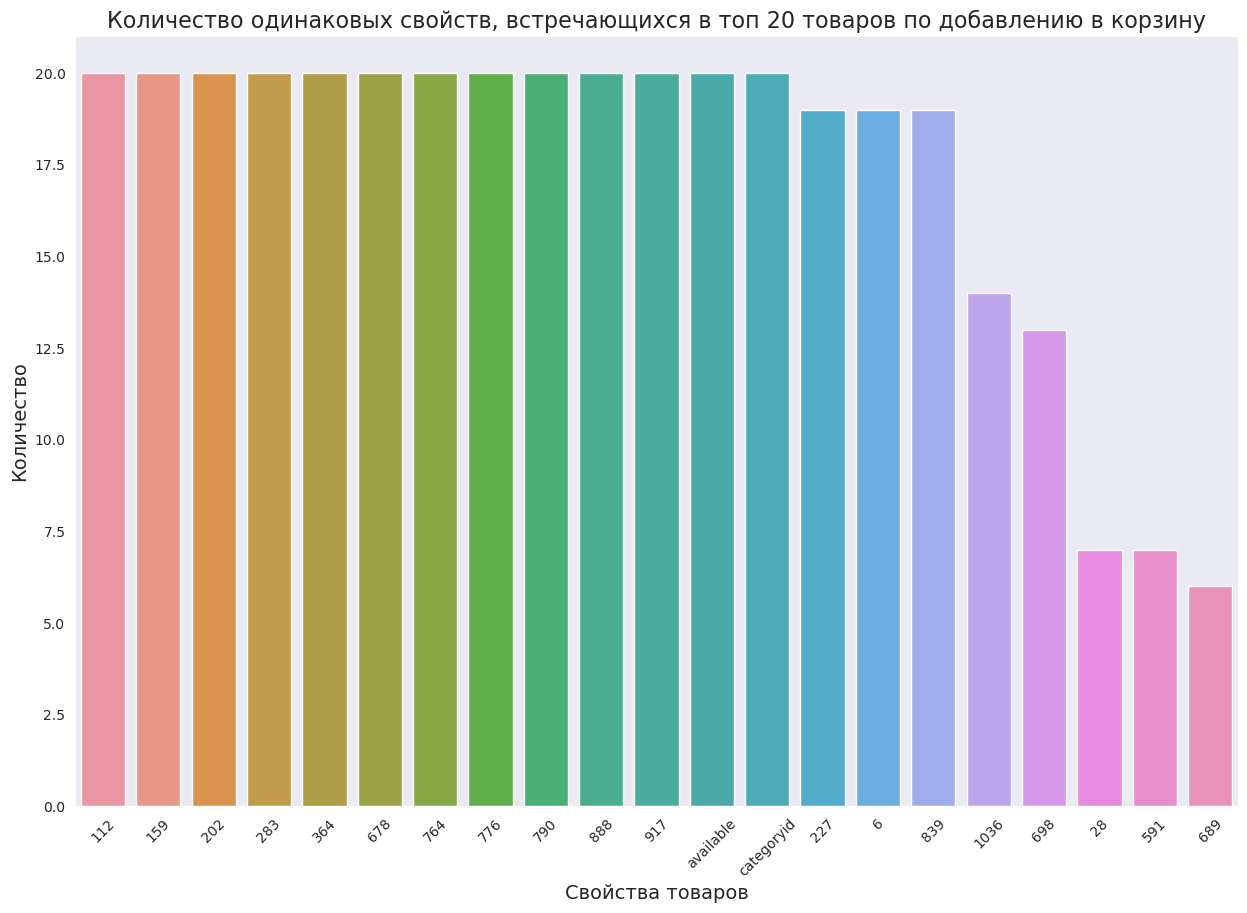

In [53]:
plt.figure(figsize = (15, 10))
sns.barplot(data_top_addtocart_property.iloc[:,:21])
plt.title('Количество одинаковых свойств, встречающихся в топ 20 товаров по добавлению в корзину', fontsize = 16)
plt.xlabel('Свойства товаров', fontsize = 14)
plt.ylabel('Количество', fontsize = 14)
plt.xticks(rotation = 45)
plt.show()

Все топ 20 товаров по добавлению в корзину объединяет 13 общих свойств.

**Находим общие свойства товаров из топ 20 по покупкам**

In [54]:
# Получаем список идентификаторов товаров из топ 20 по покупкам
list_top_transaction = top_item_transaction.index.to_list()

# Выбираем  свойства топ 20 товаров из таблицы со свойствами товаров

# Создаем пустое множество для хранения свойств товаров
property_list_transaction = set()
# Для подсчета общих свойств товаров в топ 20 создаем список 
full_property_list_transaction = []

# Создаем словарь для хранения товара и его свойств
property_transaction = {}

# Создаем цикл для извлечения свойст товаров
for item in list_top_transaction:
    list_property = sorted(list(set(data_properties.loc[data_properties['itemid'] == item]['property'].values.tolist())))
    set_prop = set(data_properties.loc[data_properties['itemid'] == item]['property'].values.tolist())
    property_transaction[item] = list_property
    property_list_transaction = property_list_transaction.union(set_prop)
    full_property_list_transaction = full_property_list_transaction + list_property
    
# Преобразуем множество в отсортированный список
property_list_transaction = sorted(list(property_list_transaction))

# Создаем словарь из списка свойств товара
dict_property_transaction = dict(Counter(full_property_list_transaction))
sort_dict_property_transaction = dict(sorted(dict_property_transaction.items(), key = lambda item: item[1], reverse = True))

# Преобразуем словарь в DataFrame
data_top_transaction_property = pd.DataFrame(sort_dict_property_transaction, index=[0])

In [55]:
# Визуализируем только 20 совпадающие свойства
data_top_transaction_property.iloc[:,:21]

,112,159,202,283,364,678,764,776,790,888,...,available,categoryid,6,839,227,698,1036,928,28,689
0,20,20,20,20,20,20,20,20,20,20,...,20,20,19,19,18,14,10,9,7,7


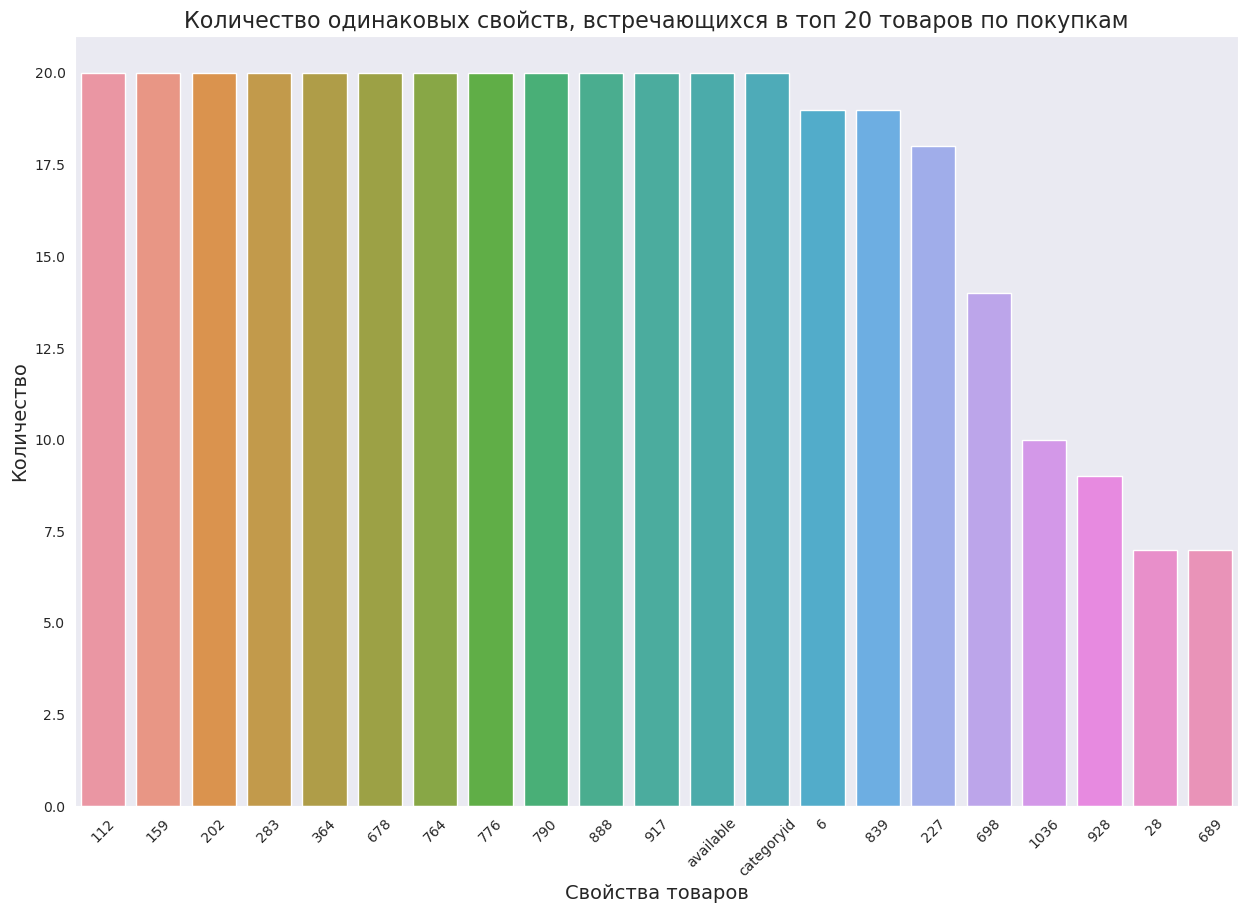

In [56]:
plt.figure(figsize = (15, 10))
sns.barplot(data_top_transaction_property.iloc[:,:21])
plt.title('Количество одинаковых свойств, встречающихся в топ 20 товаров по покупкам', fontsize = 16)
plt.xlabel('Свойства товаров', fontsize = 14)
plt.ylabel('Количество', fontsize = 14)
plt.xticks(rotation = 45)
plt.show()

Все топ 20 товаров по покупкам объединяет 13 общих свойств.

#### Рассчитаем конверсию сайта

In [57]:
conv_cart = (len(data_events[data_events['event'] == 'addtocart']) / len(data_events[data_events['event'] == 'view'])) * 100

In [58]:
print(f'Конверсия в корзину: {round(conv_cart, 2)} %')

Конверсия в корзину: 2.6 %


In [59]:
conv_transaction = (len(data_events[data_events['event'] == 'transaction']) / len(data_events[data_events['event'] == 'addtocart'])) * 100

In [60]:
print(f'Конверсия в покупку: {round(conv_transaction, 2)} %')

Конверсия в покупку: 32.39 %


### Выводы

В ходе анализа данных получены  и выявлены следующие показатели:
1. Наибольшая посещаемость сайта приходится на рабочие дни недели в вечернее время.
2. Распределение активности пользователей на сайте: просмотры, добавление в корзину, покупка.
3. Выявлены самые популярные товары у покупателей: по просмотрам, по добавлению в корзину, по покупкам. Данные товары между собой не совпадают.
4. Определены самые активные пользователи сайта. Данная информация поможет составить портрет покупателя.
5. Найдены общие свойства товаров среди популярных: по просмотрам, по добавлению в корзину, по покупкам. Это поможет определить какие свойства товара влияют на принятие решения о его покупке.
6. Конверсия сайта: в корзину- 2.6%, в покупку- 32.39%